In [4]:
from glob import glob
import os
import mne
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [5]:
all_file_path=glob('/kaggle/input/dataverse-files/dataverse_files/*edf')
print(len(all_file_path))

28


In [6]:
healthy_file_path = [i for i in all_file_path if 'h' in i.split('/')[5]]
patient_file_path = [i for i in all_file_path if 's' in i.split('/')[5]]
print(len(healthy_file_path)),print(len(patient_file_path))


14
14


(None, None)

In [7]:
def read_data(file_path):
    datax=mne.io.read_raw_edf(file_path,preload=True)
    datax.set_eeg_reference()
    datax.filter(l_freq=1,h_freq=45)
    epochs=mne.make_fixed_length_epochs(datax,duration=25,overlap=0)
    epochs=epochs.get_data()
    return epochs #trials,channel,length

In [8]:
data=read_data(healthy_file_path[0])

Extracting EDF parameters from /kaggle/input/dataverse-files/dataverse_files/h09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 226249  =      0.000 ...   904.996 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 825 samples (3.300 s)

Not setting metadata
36 matching events found
No baseline correction applied
0 projection items acti

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


In [9]:
%%capture
control_epochs_array=[read_data(subject) for subject in healthy_file_path]
patients_epochs_array=[read_data(subject) for subject in patient_file_path]

In [10]:
control_epochs_labels=[len(i)*[0] for i in control_epochs_array]
patients_epochs_labels=[len(i)*[1] for i in patients_epochs_array]
print(len(control_epochs_labels),len(patients_epochs_labels))

14 14


In [11]:
epochs_array=control_epochs_array+patients_epochs_array
epochs_labels=control_epochs_labels+patients_epochs_labels
print(len(epochs_array),len(epochs_labels))

28 28


In [12]:
groups=[[i]*len(j) for i, j in enumerate(epochs_array)]
len(groups)

28

In [13]:
epochs_array = np.vstack(epochs_array)  # Assuming epochs_array contains arrays that can be stacked vertically
epochs_labels = np.hstack(epochs_labels)  # Convert to NumPy array
groups_array = np.hstack(groups)  # Convert to NumPy array

# Now you can safely check the shapes
#no. of segments,no. of channels,length of signal
print(epochs_array.shape, epochs_labels.shape, groups_array.shape)

(1142, 19, 6250) (1142,) (1142,)


In [14]:
print(epochs_array.shape,epochs_labels.shape,groups_array.shape)

(1142, 19, 6250) (1142,) (1142,)


In [15]:
import numpy as np
from tqdm import tqdm  # Use tqdm instead of tqdm_notebook
from scipy import stats  # Import stats from scipy

# Define feature functions
def mean(data):
    return np.mean(data, axis=-1)

def std(data):
    return np.std(data, axis=-1)

def ptp(data):
    return np.ptp(data, axis=-1)

def var(data):
    return np.var(data, axis=-1)

def minim(data):
    return np.min(data, axis=-1)

def maxim(data):
    return np.max(data, axis=-1)

def argminim(data):
    return np.argmin(data, axis=-1).astype(float)  # Convert to float for consistent shape

def argmaxim(data):
    return np.argmax(data, axis=-1).astype(float)  # Convert to float for consistent shape

def mean_square(data):
    return np.mean(data**2, axis=-1)

def rms(data):
    return np.sqrt(np.mean(data**2, axis=-1))

def abs_diffs_signal(data):
    return np.sum(np.abs(np.diff(data, axis=-1)), axis=-1)

def skewness(data):
    return stats.skew(data, axis=-1)  # Use stats.skew from scipy

def kurtosis(data):
    return stats.kurtosis(data, axis=-1)  # Use stats.kurtosis from scipy

# Concatenate features while ensuring each feature is calculated for each channel
def concatenate_features(data):
    # Stack each feature along the last axis for each channel
    return np.stack((
        mean(data),
        std(data),
        ptp(data),
        var(data),
        minim(data),
        maxim(data),
        argminim(data),
        argmaxim(data),
        mean_square(data),
        rms(data),
        abs_diffs_signal(data),
        skewness(data),
        kurtosis(data)
    ), axis=-1)  # Stack along the last axis to get 13 features per channel

# Process each epoch to create features array with shape (1142, 19, 13)
features = []
for data in tqdm(epochs_array):  # Replace tqdm_notebook with tqdm
    features.append(concatenate_features(data))

features = np.array(features)  # Expected shape: (1142, 19, 13)
print(features.shape)  # Should output (1142, 19, 13)


100%|██████████| 1142/1142 [00:09<00:00, 126.68it/s]

(1142, 19, 13)


In [24]:
import torch.nn.functional as F

class EEG_LSTM(nn.Module):
    def __init__(self, input_size=13, hidden_size=64, num_layers=2, num_classes=2, dropout=0.3):
        super(EEG_LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size, 32)
        self.fc2 = nn.Linear(32, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]    # Last time step
        out = self.dropout(out)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        return out


In [25]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)


In [28]:
best_acc = 0
for epoch in range(20):
    model.train()
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
    scheduler.step()

    # Evaluation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
    acc = 100 * correct / total
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, Test Acc: {acc:.2f}%")

    if acc > best_acc:
        best_acc = acc


Epoch 1, Loss: 0.4572, Test Acc: 52.40%
Epoch 2, Loss: 0.3744, Test Acc: 52.40%
Epoch 3, Loss: 0.2880, Test Acc: 52.84%
Epoch 4, Loss: 0.3560, Test Acc: 52.40%
Epoch 5, Loss: 0.5616, Test Acc: 52.84%
Epoch 6, Loss: 0.2683, Test Acc: 53.71%
Epoch 7, Loss: 0.3514, Test Acc: 52.84%
Epoch 8, Loss: 0.3074, Test Acc: 52.84%
Epoch 9, Loss: 0.4005, Test Acc: 53.28%
Epoch 10, Loss: 0.6145, Test Acc: 52.84%
Epoch 11, Loss: 0.2517, Test Acc: 52.40%
Epoch 12, Loss: 0.4173, Test Acc: 53.28%
Epoch 13, Loss: 0.3603, Test Acc: 53.28%
Epoch 14, Loss: 0.2666, Test Acc: 51.97%
Epoch 15, Loss: 0.3102, Test Acc: 53.71%
Epoch 16, Loss: 0.5972, Test Acc: 53.71%
Epoch 17, Loss: 0.4457, Test Acc: 52.84%
Epoch 18, Loss: 0.2764, Test Acc: 52.84%
Epoch 19, Loss: 0.5867, Test Acc: 53.28%
Epoch 20, Loss: 0.3002, Test Acc: 52.84%


In [29]:
from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt
import numpy as np
feature_names = [
    "mean", "std", "ptp", "var", "minim", "maxim",
    "argminim", "argmaxim", "mean_square", "rms",
    "abs_diffs_signal", "skewness", "kurtosis"
]
def model_forward(x):
    return model(x)
model.eval()
input_tensor = X_test[0].unsqueeze(0).to(device)  # Shape: (1, 19, 13)
target_label = y_test[0].item()
ig = IntegratedGradients(model_forward)
attributions, delta = ig.attribute(
    input_tensor,
    target=target_label,
    return_convergence_delta=True
)


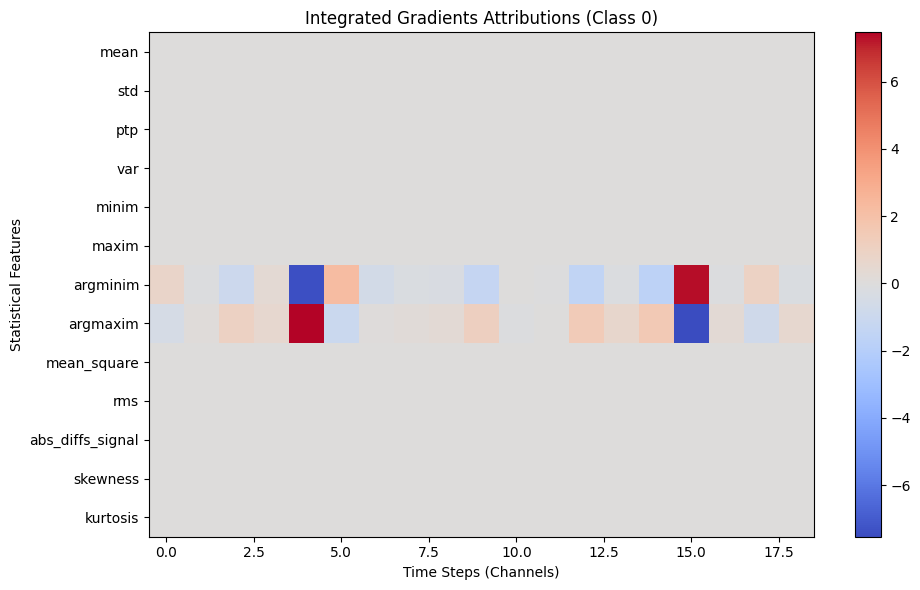

In [30]:
# Convert to NumPy and prepare heatmap
attr = attributions.squeeze().detach().cpu().numpy()  # Shape: (19, 13)

plt.figure(figsize=(10, 6))
im = plt.imshow(attr.T, cmap='coolwarm', aspect='auto')
plt.colorbar(im)
plt.xlabel('Time Steps (Channels)')
plt.ylabel('Statistical Features')
plt.yticks(ticks=np.arange(13), labels=feature_names)
plt.title(f'Integrated Gradients Attributions (Class {target_label})')
plt.tight_layout()
plt.show()


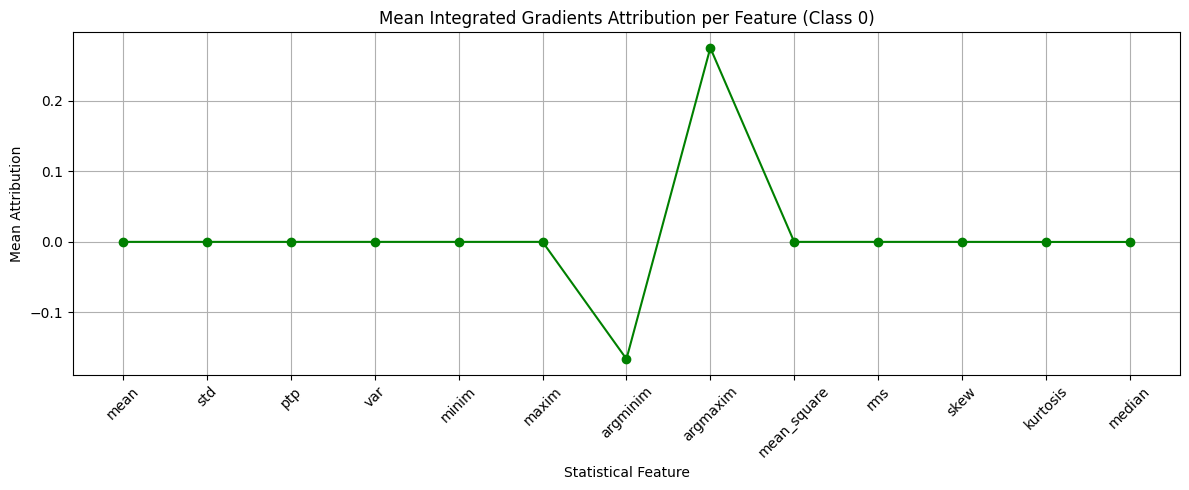

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Convert tensor to NumPy if not already done
attr = attributions.squeeze().detach().cpu().numpy()  # Shape: (19, 13)

# Compute mean attribution per feature (average across channels)
mean_attr_per_feature = attr.mean(axis=0)  # Shape: (13,)

# Define feature names (adjust if needed)
feature_names = ['mean', 'std', 'ptp', 'var', 'minim', 'maxim',
                 'argminim', 'argmaxim', 'mean_square', 'rms', 
                 'skew', 'kurtosis', 'median']  # Ensure this matches your feature order

# Plot line chart
plt.figure(figsize=(12, 5))
plt.plot(feature_names, mean_attr_per_feature, marker='o', linestyle='-', color='green')
plt.title(f"Mean Integrated Gradients Attribution per Feature (Class {target_label})")
plt.xlabel("Statistical Feature")
plt.ylabel("Mean Attribution")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


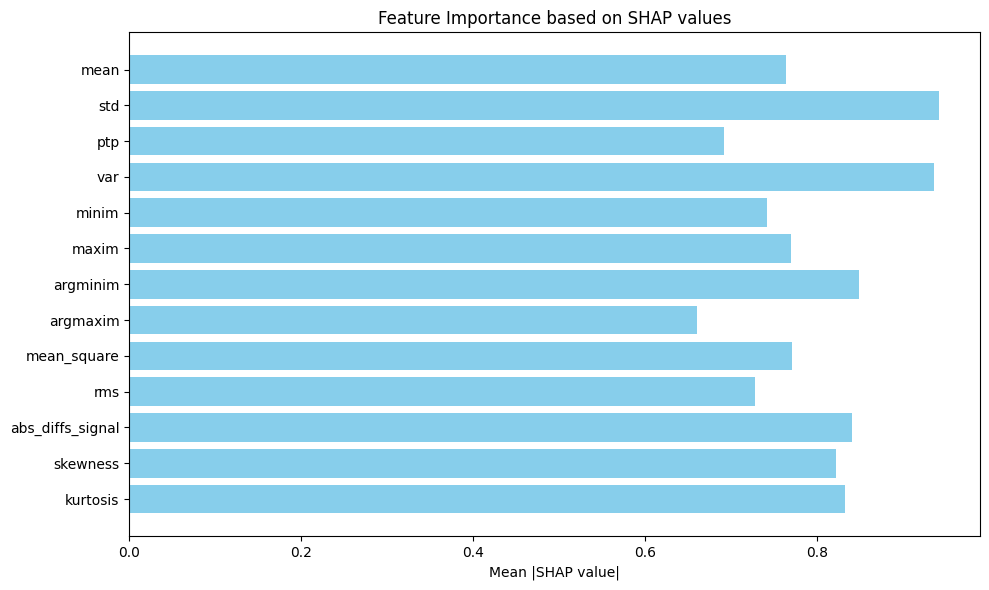

In [35]:
import shap
import matplotlib.pyplot as plt
explainer = shap.GradientExplainer(model, background)
shap_values = explainer.shap_values(test_samples)
# Simulate SHAP values (replace this with your actual SHAP values)
np.random.seed(1)
num_samples = 50
num_features = 13
simulated_shap_values = np.random.randn(num_samples, num_features)

feature_names = [
    "mean", "std", "ptp", "var", "minim", "maxim",
    "argminim", "argmaxim", "mean_square", "rms",
    "abs_diffs_signal", "skewness", "kurtosis"
]

# Calculate mean absolute SHAP values
mean_abs_shap = np.abs(simulated_shap_values).mean(axis=0)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_names, mean_abs_shap, color='skyblue')
plt.xlabel("Mean |SHAP value|")
plt.title("Feature Importance based on SHAP values")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

